In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import glob

TESTSET_SIZE = 193

In [2]:
os.getcwd()
os.chdir("..")
os.getcwd()

'/hpi/fs00/home/andrea.nathansen/protein-prompt-tuning'

In [3]:
def get_number_hmmer_recognized_sequences(hmmer_result_filepath):
    # The resulting tabular files are in a format that they can't be read
    # as a normal dataframe. So we count the lines that do not start with #
    # and are not empty, because those are the entries of recognized sequences
    with open(hmmer_result_filepath, "r") as f:
        lines = f.readlines()
        recognized_sequences = 0
        for line in lines:
            if not (line.startswith('#') or line == ''):
                recognized_sequences += 1
    return recognized_sequences

In [4]:
def get_percentage_hmmer_recognized_sequences_testset_size(hmmer_result_filepath):
    # assuming a dataset with the same size as the testset
    return get_number_hmmer_recognized_sequences(hmmer_result_filepath) / TESTSET_SIZE * 100

In [5]:
def get_percentage_hmmer_recognized_sequences_prompttuning(hmmer_result_filepaths):
    percentages_recognized = np.array([get_percentage_hmmer_recognized_sequences_testset_size(filepath) for filepath in hmmer_result_filepaths])
    return percentages_recognized.mean(), percentages_recognized.std()

In [6]:
def get_perplexities_ablation(result_df):
    # Aggregate over runs with different random seeds for prompt-tuned models.
    # Ablation is done on validation set.
    return result_df["val"].mean(), result_df["val"].std()

In [7]:
def get_perplexities_trainvaltest(result_df):
    # Aggregate over runs with different random seeds for prompt-tuned models.
    # Results for training, validation and test set
    return result_df["train"].mean(), result_df["train"].std(), result_df["val"].mean(), result_df["val"].std(), result_df["test"].mean(), result_df["test"].std()

In [8]:
def get_perplexities_comparison_to_basemodel(result_df):
    # Aggregate over runs with different random seeds for prompt-tuned models.
    # Base model model wasn't affected by different random seeds.
    return result_df["prompt_tuned"].mean(), result_df["prompt_tuned"].std(), result_df["base"][0]

In [9]:
def get_testset_perplexities_from_trainvaltest_finetuned(result_df):
    # Finetuned model has only one run per configuration
    return result_df["test"].iloc[0]

In [10]:
def get_results_protcnn_family_percentage_single_df(result_df):
    # The percentage of proteins that were classified as the family
    return (result_df["is_family"].sum() / len(result_df["is_family"])) * 100

In [11]:
def get_results_protcnn_precision_recall_metrics(positives_df, negative_dfs):
    # Precision and recall for classification of the family, for a dataset
    # that actually belongs to that family and negative control datasets
    negative_df_concatenated = pd.concat([df for df in negative_dfs])
    true_positives = positives_df["is_family"].sum()
    false_negatives = len(positives_df) - true_positives
    false_positives = negative_df_concatenated["is_family"].sum()
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    return precision, recall

In [12]:
def get_results_protcnn_family_percentage_aggregated(result_dfs):
    percentages = [get_results_protcnn_family_percentage_single_df(df) for df in result_dfs]
    return np.mean(percentages), np.std(percentages)

In [13]:
def get_results_protcnn_family_percentage_concatenated(result_dfs):
    percentage = get_results_protcnn_family_percentage_single_df(pd.concat([df for df in result_dfs]))
    return percentage

In [14]:
def get_peak_ram_usage(result_df):
    return result_df["total_peak"].max()

In [15]:
def generate_results_table_protcnn_datasets(column_names, row_names, result_dfs_protcnn_configurations):
    table=pd.DataFrame(columns=column_names, index=row_names)

    for j, result_dfs_protcnn_datasets in enumerate(result_dfs_protcnn_configurations):
        for i, result_dfs_protcnn_dataset in enumerate(result_dfs_protcnn_datasets):
            # results for datasets might be split into multiple dataframes for sets with large sequences
            if isinstance(result_dfs_protcnn_dataset, list):
                r_dataset = get_results_protcnn_family_percentage_concatenated(result_dfs_protcnn_dataset)
            else:
                r_dataset = get_results_protcnn_family_percentage_single_df(result_dfs_protcnn_dataset)
            table[column_names[i]].loc[row_names[j]] = f"{np.round(r_dataset, decimals=1)}"
    return table

In [16]:
def generate_precision_recall_table_protcnn_datasets(row_names, result_dfs_positive_protcnn_configurations, result_dfs_negative_protcnn_configurations):
    table=pd.DataFrame(columns=["Precision", "Recall"], index=row_names)
    
    for i, result_dfs_protcnn_datasets in enumerate(zip(result_dfs_positive_protcnn_configurations, result_dfs_negative_protcnn_configurations)):
        result_df_positive_datasets, result_dfs_negative_datasets = result_dfs_protcnn_datasets
        precision, recall = get_results_protcnn_precision_recall_metrics(result_df_positive_datasets, result_dfs_negative_datasets)
        table.loc[row_names[i]] = {"Precision": f"{np.round(precision, decimals=2)}", "Recall": f"{np.round(recall, decimals=2)}"}
    return table

In [17]:
def generate_results_table_protcnn_comparison(column_names, result_dfs_protcnn_prompttuned, result_dfs_protcnn_finetuned, result_dfs_protcnn_basemodel):
    table=pd.DataFrame(columns=column_names, index=["Prompt-tuned model (ours)", "Finetuned model", "Base model"])
    for i, dfs in enumerate(zip(result_dfs_protcnn_prompttuned, result_dfs_protcnn_finetuned, result_dfs_protcnn_basemodel)):
        result_dfs_protcnn_prompttuned_seeds, result_df_protcnn_finetuned, result_df_protcnn_basemodel = dfs
        r_prompttuned_mean, r_prompttuned_std = get_results_protcnn_family_percentage_aggregated(result_dfs_protcnn_prompttuned_seeds)
        r_finetuned = get_results_protcnn_family_percentage_single_df(result_df_protcnn_finetuned)
        r_basemodel = get_results_protcnn_family_percentage_single_df(result_df_protcnn_basemodel)
        table[column_names[i]] = [f"{np.round(r_prompttuned_mean, decimals=2)} ± {np.round(r_prompttuned_std, decimals=2)}",
                                  np.round(r_finetuned, decimals=2),
                                  np.round(r_basemodel, decimals=2)]
    return table

In [34]:
def generate_results_table_protcnn_for_clustering_comparison(column_names, result_dfs_protcnn_prompttuned):
    table=pd.DataFrame(columns=column_names, index=["Prompt-tuned model (ours)"])
    for i, dfs in enumerate(result_dfs_protcnn_prompttuned):
        r_prompttuned_mean, r_prompttuned_std = get_results_protcnn_family_percentage_aggregated(dfs)
        table[column_names[i]] = [f"{np.round(r_prompttuned_mean, decimals=2)} ± {np.round(r_prompttuned_std, decimals=2)}"]
    return table

In [18]:
def generate_perplexities_table_for_clustering_comparison(column_names, result_dfs_clusterings):
    table=pd.DataFrame(columns=column_names, index=["Train", "Validation", "Test"])
    for i, df in enumerate(result_dfs_clusterings):
            r_train_mean, r_train_std, r_val_mean, r_val_std, r_test_mean, r_test_std, = get_perplexities_trainvaltest(df)
            table[column_names[i]] = [f"{np.round(r_train_mean, decimals=2)} ± {np.round(r_train_std, decimals=2)}", f"{np.round(r_val_mean, decimals=2)} ± {np.round(r_val_std, decimals=2)}", f"{np.round(r_test_mean, decimals=2)} ± {np.round(r_test_std, decimals=2)}"]
    return table

In [19]:
def generate_perplexities_table_for_ablation_study(column_names, row_names, result_dfs_ablations):
    table=pd.DataFrame(columns=column_names, index=row_names)
    for j, result_dfs_for_ablation in enumerate(result_dfs_ablations):
        for i, df in enumerate(result_dfs_for_ablation):
            r_mean, r_std = get_perplexities_ablation(df)
            table[column_names[i]][row_names[j]] = f"{np.round(r_mean, decimals=2)} ± {np.round(r_std, decimals=2)}"
    return table

In [20]:
def generate_perplexities_table_for_comparison_to_basemodel(column_names, result_dfs):
    table=pd.DataFrame(columns=column_names, index=["Prompt-tuned model (ours)", "Base model"])
    for i, df in enumerate(result_dfs):
        r_prompttuned_mean, r_prompttuned_std, r_basemodel = get_perplexities_comparison_to_basemodel(df)
        table[column_names[i]] = [f"{np.round(r_prompttuned_mean, decimals=2)} ± {np.round(r_prompttuned_std, decimals=2)}", np.round(r_basemodel, decimals=2)]
    return table

In [21]:
def generate_perplexities_table_comparison_prompttuned_finetuned_basemodel(column_names, result_dfs_prompttuned_basemodel, result_dfs_finetuned):
    table=pd.DataFrame(columns=column_names, index=["Prompt-tuned model (ours)", "Finetuned model", "Base model"])
    for i, dfs in enumerate(zip(result_dfs_prompttuned_basemodel, result_dfs_finetuned)):
        result_df_prompttuned_basemodel, result_df_finetuned = dfs
        r_prompttuned_mean, r_prompttuned_std, r_basemodel = get_perplexities_comparison_to_basemodel(result_df_prompttuned_basemodel)
        r_finetuned = get_testset_perplexities_from_trainvaltest_finetuned(result_df_finetuned)
        table[column_names[i]] = [f"{np.round(r_prompttuned_mean, decimals=2)} ± {np.round(r_prompttuned_std, decimals=2)}",
                                  np.round(r_finetuned, decimals=2),
                                  np.round(r_basemodel, decimals=2)]
    return table

In [22]:
def generate_hmmer_results_table_comparison_prompttuned_finetuned_basemodel(column_names,
                                                                            hmmer_result_paths_prompttuned,
                                                                            hmmer_result_paths_basemodel,
                                                                            hmmer_result_paths_finetuned):
    table=pd.DataFrame(columns=column_names, index=["Prompt-tuned model (ours)", "Finetuned model", "Base model"])
    for i, hmmer_result_paths in enumerate(zip(hmmer_result_paths_prompttuned, hmmer_result_paths_basemodel, hmmer_result_paths_finetuned)):
        rp_prompttuned, rp_basemodel, rp_finetuned = hmmer_result_paths
        r_prompttuned_mean, r_prompttuned_std = get_percentage_hmmer_recognized_sequences_prompttuning(rp_prompttuned)
        r_basemodel = get_percentage_hmmer_recognized_sequences_testset_size(rp_basemodel)
        r_finetuned = get_percentage_hmmer_recognized_sequences_testset_size(rp_finetuned)
        table[column_names[i]] = [f"{np.round(r_prompttuned_mean, decimals=2)} ± {np.round(r_prompttuned_std, decimals=2)}",
                                  np.round(r_finetuned, decimals=2),
                                  np.round(r_basemodel, decimals=2)]
    return table
    

In [23]:
def generate_ram_usages_table_comparison_prompttuned_finetuned(column_names,
                                                                            result_dfs_prompttuned,
                                                                            result_dfs_finetuned):
    table=pd.DataFrame(columns=column_names, index=["Prompt-tuned model (ours)", "Finetuned model"])
    for i, dfs in enumerate(zip(result_dfs_prompttuned, result_dfs_finetuned)):
        result_df_prompttuned, result_df_finetuned = dfs
        r_prompttuned = get_peak_ram_usage(result_df_prompttuned)
        r_finetuned = get_peak_ram_usage(result_df_finetuned)
        table[column_names[i]] = [r_prompttuned,
                                  r_finetuned]
    return table

# Results of prompt tuning (with defaults) for all model sizes, comparison to base model and finetuned model

In [16]:
test_results_defaults_S = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-100-RITA_s-fromvocab-True-test_perplexity_comparison.csv")
test_results_defaults_M = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-100-RITA_m-fromvocab-True-test_perplexity_comparison.csv")
test_results_defaults_L = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-100-RITA_l-fromvocab-True-test_perplexity_comparison.csv")
test_results_defaults_XL = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-100-RITA_xl-fromvocab-True-test_perplexity_comparison.csv")

In [20]:
test_results_finetuned_S = pd.read_csv("experiment_results/perplexities/finetuned-RITA_s-trainvaltest_comparison.csv")
test_results_finetuned_M = pd.read_csv("experiment_results/perplexities/finetuned-RITA_m-trainvaltest_comparison.csv")
test_results_finetuned_L = pd.read_csv("experiment_results/perplexities/finetuned-RITA_l-trainvaltest_comparison.csv")
test_results_finetuned_XL = pd.read_csv("experiment_results/perplexities/finetuned-RITA_xl-trainvaltest_comparison.csv")

In [33]:
table_defaults_all_sizes = generate_perplexities_table_comparison_prompttuned_finetuned_basemodel(["S", "M", "L", "XL"], [test_results_defaults_S, test_results_defaults_M, test_results_defaults_L, test_results_defaults_XL],
                                                                              [test_results_finetuned_S, test_results_finetuned_M, test_results_finetuned_L, test_results_finetuned_XL])
table_defaults_all_sizes.to_csv("experiment_results/final_tables/results_perplexity_model_sizes.csv")
table_defaults_all_sizes

,S,M,L,XL
Prompt-tuned model (ours),8.73 ± 0.1,7.25 ± 0.19,6.01 ± 0.5,5.96 ± 0.72
Finetuned model,1.49,1.39,1.37,1.38
Base model,13.93,12.31,9.65,6.98


# Results for ablation study random uniform init VS from vocab

In [24]:
trainvaltest_results_fromvocab_S = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-100-RITA_s-fromvocab-True-trainvaltest_comparison.csv")
trainvaltest_results_fromvocab_M = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-100-RITA_m-fromvocab-True-trainvaltest_comparison.csv")

In [25]:
trainvaltest_results_randomuniform_S = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-100_s_random_init-RITA_s-fromvocab-False-trainvaltest_comparison.csv")
trainvaltest_results_randomuniform_M = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-100_m_random_init-RITA_m-fromvocab-False-trainvaltest_comparison.csv")

In [26]:
table_ablation_study = generate_perplexities_table_for_ablation_study(["S", "M"], ["Sampled Vocab", "Random Uniform"],[[trainvaltest_results_fromvocab_S, trainvaltest_results_fromvocab_M], [trainvaltest_results_randomuniform_S, trainvaltest_results_randomuniform_M]])
table_ablation_study.to_csv("experiment_results/final_tables/results_perplexity_ablation_study.csv")
table_ablation_study

,S,M
Sampled Vocab,8.21 ± 0.08,6.8 ± 0.17
Random Uniform,8.18 ± 0.19,7.05 ± 0.33


# Results for different clustering sequence similarity thresholds

In [17]:
trainvaltest_results_clustering_100 = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-100-RITA_s-fromvocab-True-trainvaltest_comparison.csv")
trainvaltest_results_clustering_95 = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-95-RITA_s-fromvocab-True-trainvaltest_comparison.csv")
trainvaltest_results_clustering_65 = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-65-RITA_s-fromvocab-True-trainvaltest_comparison.csv")
trainvaltest_results_clustering_35 = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-35-RITA_s-fromvocab-True-trainvaltest_comparison.csv")

In [18]:
table_trainvaltest_clustering = generate_perplexities_table_for_clustering_comparison([100, 95, 65, 35], [trainvaltest_results_clustering_100,trainvaltest_results_clustering_95, trainvaltest_results_clustering_65, trainvaltest_results_clustering_35])
table_trainvaltest_clustering.to_csv("experiment_results/final_tables/results_perplexity_clustering_trainvaltest.csv")
table_trainvaltest_clustering

,100,95,65,35
Train,8.25 ± 0.08,10.13 ± 0.03,11.72 ± 0.1,11.66 ± 0.12
Validation,8.21 ± 0.08,9.65 ± 0.02,13.08 ± 0.1,12.15 ± 0.06
Test,8.73 ± 0.1,9.64 ± 0.02,12.67 ± 0.08,13.49 ± 0.07


In [19]:
basemodel_results_clustering_100 = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-100-RITA_s-fromvocab-True-test_perplexity_comparison.csv")
basemodel_results_clustering_95 = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-95-RITA_s-fromvocab-True-test_perplexity_comparison.csv")
basemodel_results_clustering_65 = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-65-RITA_s-fromvocab-True-test_perplexity_comparison.csv")
basemodel_results_clustering_35 = pd.read_csv("experiment_results/perplexities/prompt-tuning-clustered-35-RITA_s-fromvocab-True-test_perplexity_comparison.csv")

In [20]:
table_basemodelcomparison_clustering = generate_perplexities_table_for_comparison_to_basemodel([100, 95, 65, 35], [basemodel_results_clustering_100, basemodel_results_clustering_95, basemodel_results_clustering_65, basemodel_results_clustering_35])
table_basemodelcomparison_clustering.to_csv("experiment_results/final_tables/results_perplexity_clustering_basemodelcomparison.csv")
table_basemodelcomparison_clustering

,100,95,65,35
Prompt-tuned model (ours),8.73 ± 0.1,9.64 ± 0.02,12.67 ± 0.08,13.49 ± 0.07
Base model,13.93,12.99,13.83,14.24


# Results for protCNN predictions

## Results for test dataset and negative control datasets
For different ProtCNN configurations

In [62]:
protcnn_results_testset_single = pd.read_csv("experiment_results/protcnn-eval_single/InterProUniprotPF03272prepared_test.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.0.csv")
protcnn_results_otherfamilies_single = pd.read_csv("experiment_results/protcnn-eval_single/other-families.fasta_protcnn_results_flexible_windowsize_stride1.csv")
protcnn_results_shuffled_single = pd.read_csv("experiment_results/protcnn-eval_single/esl-shuffled.fasta_protcnn_results_flexible_windowsize_stride1.csv")


protcnn_results_testset_ensemble2 = pd.read_csv("experiment_results/protcnn-eval-ensemble-2/InterProUniprotPF03272prepared_test.fasta_protcnn_results_flexible_windowsize_stride1_ensemble2.csv")
protcnn_results_otherfamilies_ensemble2 = [pd.read_csv(result_csv) for result_csv in glob.glob("experiment_results/protcnn-eval-ensemble-2/other-families*")]
protcnn_results_shuffled_ensemble2 = pd.read_csv("experiment_results/protcnn-eval-ensemble-2/esl-shuffled.fasta_protcnn_results_flexible_windowsize_stride1_ensemble2.csv")

protcnn_results_testset_ensemble3 = pd.read_csv("experiment_results/protcnn-eval-ensemble-3/InterProUniprotPF03272prepared_test.fasta_protcnn_results_flexible_windowsize_stride1.csv")
protcnn_results_otherfamilies_ensemble3 = [pd.read_csv(result_csv) for result_csv in glob.glob("experiment_results/protcnn-eval-ensemble-3/other-families*")]
protcnn_results_shuffled_ensemble3 = pd.read_csv("experiment_results/protcnn-eval-ensemble-3/esl-shuffled.fasta_protcnn_results_flexible_windowsize_stride1.csv")

protcnn_results_testset_threshold = pd.read_csv("experiment_results/protcnn-eval-threshold0.5/InterProUniprotPF03272prepared_test.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv")
protcnn_results_otherfamilies_threshold = [pd.read_csv(result_csv) for result_csv in glob.glob("experiment_results/protcnn-eval-threshold0.5/other-families*")]
protcnn_results_shuffled_threshold = pd.read_csv("experiment_results/protcnn-eval-threshold0.5/esl-shuffled.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv")


In [70]:
results_protcnn_datasets = generate_results_table_protcnn_datasets(column_names=["Test set", "Other families", "Shuffled"],
                                        row_names=["Single", "Ensemble 2", "Ensemble 3", "Single thresholded"], 
                                        result_dfs_protcnn_configurations=[[protcnn_results_testset_single, protcnn_results_otherfamilies_single, protcnn_results_shuffled_single],
                                                                           [protcnn_results_testset_ensemble2, protcnn_results_otherfamilies_ensemble2, protcnn_results_shuffled_ensemble2],
                                                                           [protcnn_results_testset_ensemble3, protcnn_results_otherfamilies_ensemble3, protcnn_results_shuffled_ensemble3],
                                                                           [protcnn_results_testset_threshold, protcnn_results_otherfamilies_threshold, protcnn_results_shuffled_threshold]])
results_protcnn_datasets.to_csv("experiment_results/final_tables/results_protcnn_datasets.csv")
results_protcnn_datasets

,Test set,Other families,Shuffled
Single,99.0,24.2,89.1
Ensemble 2,98.4,18.9,83.4
Ensemble 3,98.4,21.6,82.9
Single thresholded,99.0,13.2,65.3


In [72]:
results_precision_recall_protcnn_datasets = generate_precision_recall_table_protcnn_datasets(
                                        row_names=["Single", "Ensemble 2", "Ensemble 3", "Single thresholded"], 
                                        result_dfs_positive_protcnn_configurations=[protcnn_results_testset_single, protcnn_results_testset_ensemble2, protcnn_results_testset_ensemble3, protcnn_results_testset_threshold],
                                        result_dfs_negative_protcnn_configurations=[[protcnn_results_otherfamilies_single, protcnn_results_shuffled_single],
                                                                           protcnn_results_otherfamilies_ensemble2 + [protcnn_results_shuffled_ensemble2],
                                                                           protcnn_results_otherfamilies_ensemble3 + [protcnn_results_shuffled_ensemble3],
                                                                           protcnn_results_otherfamilies_threshold + [protcnn_results_shuffled_threshold]])
results_precision_recall_protcnn_datasets.to_csv("experiment_results/final_tables/results_precision_recall_protcnn_datasets.csv")
results_precision_recall_protcnn_datasets

,Precision,Recall
Single,0.47,0.99
Ensemble 2,0.49,0.98
Ensemble 3,0.49,0.98
Single thresholded,0.56,0.99


## Results for generated sequences

In [30]:
protcnn_results_clustering_100 = [pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/prompt-tuning-clustered-100-RITA_s-fromvocab-True-seed-{i}-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv") for i in range(3)]
protcnn_results_clustering_95 = [pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/prompt-tuning-clustered-95-RITA_s-fromvocab-True-seed-{i}-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv") for i in range(3)]
protcnn_results_clustering_65 = [pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/prompt-tuning-clustered-65-RITA_s-fromvocab-True-seed-{i}-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv") for i in range(3)]
protcnn_results_clustering_35 = [pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/prompt-tuning-clustered-35-RITA_s-fromvocab-True-seed-{i}-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv") for i in range(3)]
protcnn_results_basemodel = [pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/basemodel-RITA_s-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv") for i in range(3)]

In [31]:
protcnn_results_testdata = pd.read_csv("experiment_results/protcnn-eval-threshold0.5/InterProUniprotPF03272prepared_test.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv")

In [35]:
table_protcnn_comparison_clustering = generate_results_table_protcnn_for_clustering_comparison([100, 95, 65, 35], [protcnn_results_clustering_100, protcnn_results_clustering_95, protcnn_results_clustering_65, protcnn_results_clustering_35])
table_protcnn_comparison_clustering.to_csv("experiment_results/final_tables/results_protcnn_clustering.csv")
table_protcnn_comparison_clustering

,100,95,65,35
Prompt-tuned model (ours),51.3 ± 4.08,52.85 ± 3.05,53.54 ± 8.94,52.16 ± 2.09


In [14]:
protcnn_results_S = [pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/prompt-tuning-clustered-100-RITA_s-fromvocab-True-seed-{i}-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv") for i in range(3)]
protcnn_results_M = [pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/prompt-tuning-clustered-100-RITA_m-fromvocab-True-seed-{i}-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv") for i in range(3)]
protcnn_results_L = [pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/prompt-tuning-clustered-100-RITA_l-fromvocab-True-seed-{i}-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv") for i in range(3)]
protcnn_results_XL = [pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/prompt-tuning-clustered-100-RITA_xl-fromvocab-True-seed-{i}-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv") for i in range(3)]

protcnn_results_SBase = pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/basemodel-RITA_s-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv")
protcnn_results_MBase = pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/basemodel-RITA_m-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv")
protcnn_results_LBase = pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/basemodel-RITA_l-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv")
protcnn_results_XLBase = pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/basemodel-RITA_xl-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv")

protcnn_results_SFinetuned = pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/finetuned-RITA_s-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv")
protcnn_results_MFinetuned = pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/finetuned-RITA_m-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv")
protcnn_results_LFinetuned = pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/finetuned-RITA_l-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv")
protcnn_results_XLFinetuned = pd.read_csv(f"experiment_results/protcnn-eval-threshold0.5/finetuned-RITA_xl-generated.fasta_protcnn_results_flexible_windowsize_stride1_threshold0.5.csv")

In [15]:
table_protcnn_comparison_model_sizes = generate_results_table_protcnn_comparison(["S", "M", "L", "XL"],
                                                                                 [protcnn_results_S, protcnn_results_M, protcnn_results_L, protcnn_results_XL],
                                                                                 [protcnn_results_SFinetuned, protcnn_results_MFinetuned, protcnn_results_LFinetuned, protcnn_results_XLFinetuned],
                                                                                 [protcnn_results_SBase, protcnn_results_MBase, protcnn_results_LBase, protcnn_results_XLBase])

table_protcnn_comparison_model_sizes.to_csv("experiment_results/final_tables/results_protcnn_model_sizes.csv")
table_protcnn_comparison_model_sizes

,S,M,L,XL
Prompt-tuned model (ours),51.3 ± 4.08,52.16 ± 5.51,39.72 ± 1.36,24.35 ± 1.53
Finetuned model,67.36,75.13,80.31,70.47
Base model,9.84,11.92,13.47,16.58


# Results for HMMER

In [8]:
base_hmmer_result_path = "experiment_results/hmmer_results/"

hmmer_result_paths_s = [base_hmmer_result_path + f"hmmer_s_prompt-tuned_{i}.out" for i in range(3)]
hmmer_result_paths_m = [base_hmmer_result_path + f"hmmer_m_prompt-tuned_{i}.out" for i in range(3)]
hmmer_result_paths_l = [base_hmmer_result_path + f"hmmer_l_prompt-tuned_{i}.out" for i in range(3)]
hmmer_result_paths_xl = [base_hmmer_result_path + f"hmmer_xl_prompt-tuned_{i}.out" for i in range(3)]
hmmer_results_paths_pt = [hmmer_result_paths_s, hmmer_result_paths_m, hmmer_result_paths_l, hmmer_result_paths_xl]

hmmer_results_paths_bm = [base_hmmer_result_path + "hmmer_s_basemodel.out", base_hmmer_result_path + "hmmer_m_basemodel.out",
                            base_hmmer_result_path + "hmmer_l_basemodel.out", base_hmmer_result_path + "hmmer_xl_basemodel.out"]

hmmer_results_paths_ft = [base_hmmer_result_path + "hmmer_s_finetuned.out", base_hmmer_result_path + "hmmer_m_finetuned.out",
                            base_hmmer_result_path + "hmmer_l_finetuned.out", base_hmmer_result_path + "hmmer_xl_finetuned.out"]

In [9]:
table_hmmer_results_all_sizes = generate_hmmer_results_table_comparison_prompttuned_finetuned_basemodel(["S", "M", "L", "XL"],
                                                                                                        hmmer_results_paths_pt,
                                                                                                        hmmer_results_paths_bm,
                                                                                                        hmmer_results_paths_ft)
table_hmmer_results_all_sizes.to_csv("experiment_results/final_tables/results_hmmer_model_sizes.csv")
table_hmmer_results_all_sizes

,S,M,L,XL
Prompt-tuned model (ours),0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Finetuned model,24.87,33.16,48.7,54.92
Base model,0.0,0.0,0.0,0.0


# RAM usage

In [15]:
ram_prompttuned_S = pd.read_csv("experiment_results/memory_usages/memory_usage_RITA_s_prompt.csv")
ram_prompttuned_M = pd.read_csv("experiment_results/memory_usages/memory_usage_RITA_m_prompt.csv")
ram_prompttuned_L = pd.read_csv("experiment_results/memory_usages/memory_usage_RITA_l_prompt.csv")
ram_prompttuned_XL = pd.read_csv("experiment_results/memory_usages/memory_usage_RITA_xl_prompt.csv")

ram_finetuned_S = pd.read_csv("experiment_results/memory_usages/memory_usage_RITA_s_finetuned.csv")
ram_finetuned_M = pd.read_csv("experiment_results/memory_usages/memory_usage_RITA_m_finetuned.csv")
ram_finetuned_L = pd.read_csv("experiment_results/memory_usages/memory_usage_RITA_l_finetuned.csv")
ram_finetuned_XL = pd.read_csv("experiment_results/memory_usages/memory_usage_RITA_xl_finetuned.csv")

In [16]:
table_ram_results_all_sizes = generate_ram_usages_table_comparison_prompttuned_finetuned(["S", "M", "L", "XL"],
                                                                                          [ram_prompttuned_S, ram_prompttuned_M, ram_prompttuned_L, ram_prompttuned_XL],
                                                                                          [ram_finetuned_S, ram_finetuned_M, ram_finetuned_L, ram_finetuned_XL])
table_ram_results_all_sizes.to_csv("experiment_results/final_tables/results_ram_model_sizes.csv")
table_ram_results_all_sizes

,S,M,L,XL
Prompt-tuned model (ours),2890,7902,12723,18096
Finetuned model,3793,10853,18881,28621


# Activity Prediction

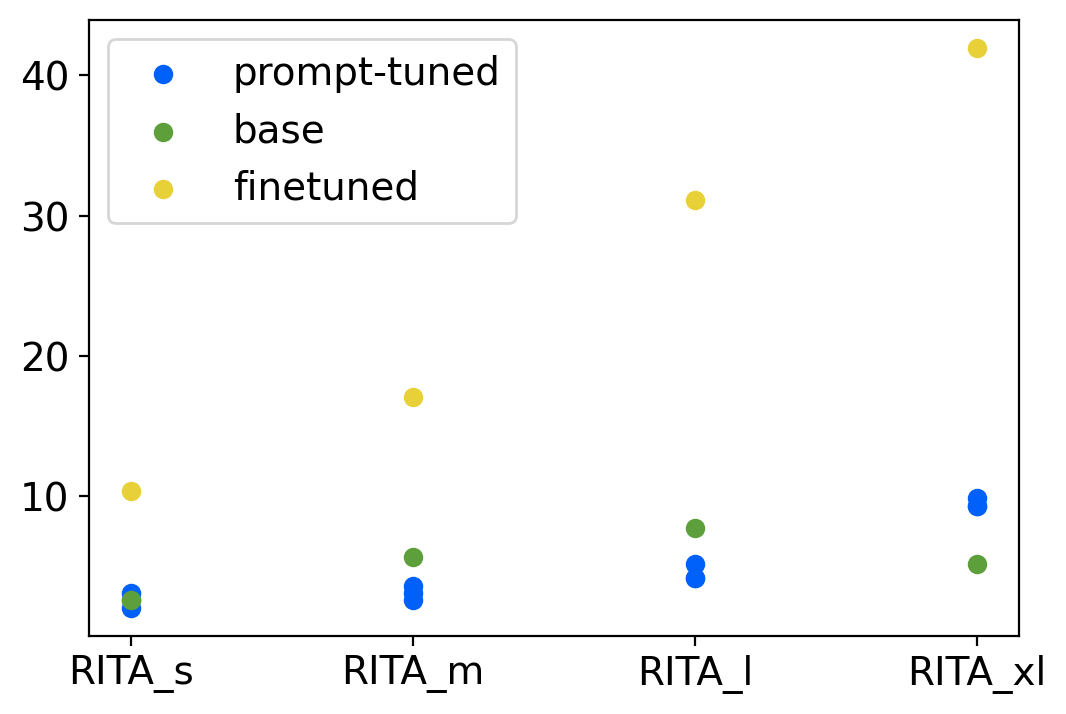

In [28]:
activity_data = pd.read_csv("../activity_prediction_metrics/test.csv").to_numpy()

plt.figure(figsize=(6,4), dpi=200)

keys, _, values = list(zip(*[t for t in activity_data if t[1] == 'pt']))
plt.scatter(keys, values, c = '#0060fa', label='prompt-tuned')

keys, _, values = list(zip(*[t for t in activity_data if t[1] == 'base']))
plt.scatter(keys, values, c = '#5da03b', label='base')

keys, _, values = list(zip(*[t for t in activity_data if t[1] == 'fine']))
plt.scatter(keys, values, c = '#e8d138', label='finetuned')

plt.rc('font', **{'size'   : '14'})

plt.legend()